# Asset Manager Project, FINS3645 #

## Station 1:  Extract, Transform, and Load ##
This is the station where we take all the data, structured and unstructured, load it and clean it uop for use in the later stations. 

First, I install all the packages needed for the project. 

In [1272]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import scipy.optimize as sco
from scipy.optimize import Bounds

# Used for the sentiment anlaysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer


### Extracting data for the sentiment analysis ###
Import the data into a pandas dataframe object. <br>
As the data is sorted by equity and then within equity by date, most recent to least, no further cleaning of the data is needed. 

In [1273]:
fileDB = "data/"  # Datalake address

news = pd.read_json(fileDB + "news_dump.json")  # Reading json file in as dataframe object

# Since the file is imported without headings, they have to be added
news.columns = ['Equity', 'Source', 'Date/Time', 'Headline']

### Extracting data for the portfolio creation ###
Extracting the data from ASX200top10.xlsx
I first manually export the data to a .csv file called ASX200top10.csv
<br>Then, I import the csv file and add the data to a pandas dataframe object

In [1274]:
# Creating dataframe object using pandas
asxtopten = pd.read_csv(fileDB + "ASX200top10.csv", skiprows=[0])  # Skipping the first row to avoid messy headers

### Extracting data for economic indicators ###
Importing the data into a pandas dataframe object. The data was processed manually beforhand as the previous csv file was too difficult to work with. 

In [1275]:
e_indicators = pd.read_csv(fileDB + "quarterly_indicators.csv")

## Station 2: Feature Engineering ##
In this section I extract features to use in the model in station 3.

#### Extracting the share prices ####
I want only the share prices in a dataframe object. Therefore, I have chosen to create a new dataframe object with all the share prices from asxtopten. I also add the date where these share prices where recorded.

In [1276]:

### CREATE DATAFRAME WITH JUST SHARE PRICES ###
shareprices = pd.DataFrame()

### Extracting only the share prices ###
shareprices["Date"] = asxtopten["Dates"]
shareprices["BHP"] = asxtopten["PX_LAST.1"].astype(float)
shareprices["CSL"] = asxtopten["PX_LAST.2"].astype(float)
shareprices["RIO"] = asxtopten["PX_LAST.3"].astype(float)
shareprices["CBA"] = asxtopten["PX_LAST.4"].astype(float)
shareprices["WOW"] = asxtopten["PX_LAST.5"].astype(float)
shareprices["WES"] = asxtopten["PX_LAST.6"].astype(float)
shareprices["TLS"] = asxtopten["PX_LAST.7"].astype(float)
shareprices["AMC"] = asxtopten["PX_LAST.8"].astype(float)
shareprices["BXB"] = asxtopten["PX_LAST.9"].astype(float)
shareprices["FPH"] = asxtopten["PX_LAST.10"].astype(float)

# shareprices now holds the date and corresponding price of all ten shares

Setting the index of the shareprices dataframe to be the date where the share prices were recorded.

In [1277]:
shareprices = shareprices.set_index("Date")

Checking the normal distribution of the share price returns. After generating the graphs it looks good.

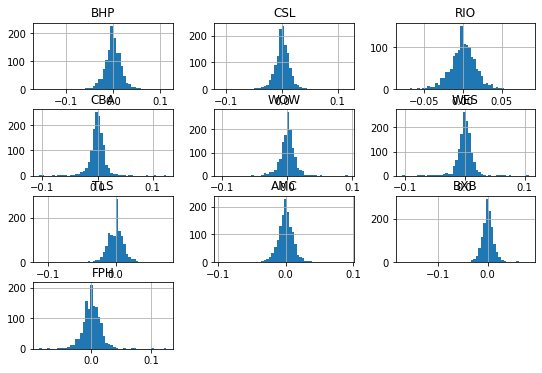

In [1278]:
rets = np.log(shareprices / shareprices.shift(1))
rets.hist(bins=50, figsize=(9,6))
plt.show()

#### Extracting the index AS51 into dataframe ####

In [1279]:
index = pd.DataFrame()
index["Date"] = asxtopten["Dates"]
index["AS51"] = asxtopten["PX_LAST"].astype(float)
index = index.set_index("Date") # Setting the index to be the date

#### Cleaning up economic indicators data ####
Removing the last three rows as they only contain NaN

In [1280]:
e_indicators.drop(e_indicators.tail(3).index, inplace = True)
e_indicators =  e_indicators[::-1]    # Reversing the order of the rows for readability
e_indicators["Date"] = pd.to_datetime(e_indicators["Date"], format="%m/%d/%Y")    # Changing the dates to datetime

## Station 3: Model Design ##

### Portfolio creator ###

For the wealth manager the user can have one of nine different risk profiles. I therefore, am putting together nine different portfolios based on the volatility. 

First I need to find the portfolios with the least and the most volatility for the past five years. Creating 10,000 different random portfolios to ensure I get both extremas. 

In [1281]:
noa = len(list(shareprices))                               # The number of assets in the portfolio
rets = np.log(shareprices / shareprices.shift(1))          # Calculating the logarithmic returns

open_days = 252                                            # Trading days in a year to annualise data

np.random.seed(1)                                          # Makes the same set of numbers appear every time.
weights = np.random.random(noa)                            # Creates random weights
weights /= np.sum(weights)

prets = []                                                 # Portfolio returns of 10000 different portfolios
pvols = []                                                 # Portfolio volatility of 10000 different portfolios
for p in range (10000):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights) * open_days)
    pvols.append(np.sqrt(np.dot(weights.T,
                                np.dot(rets.cov() * open_days, weights))))
prets = np.array(prets)  # Yearly returns
pvols = np.array(pvols)  # Yearly volatility

volmax = max(pvols)                                        
volmin = min(pvols)

Plotting the returns and volatility of the different portfolios to ensure that the assumption of higher risk, higher reward is true. As we can read off the graph this seems to be accurate enough considering the model will pick the portfolios witht he highest sharpe ratios. 

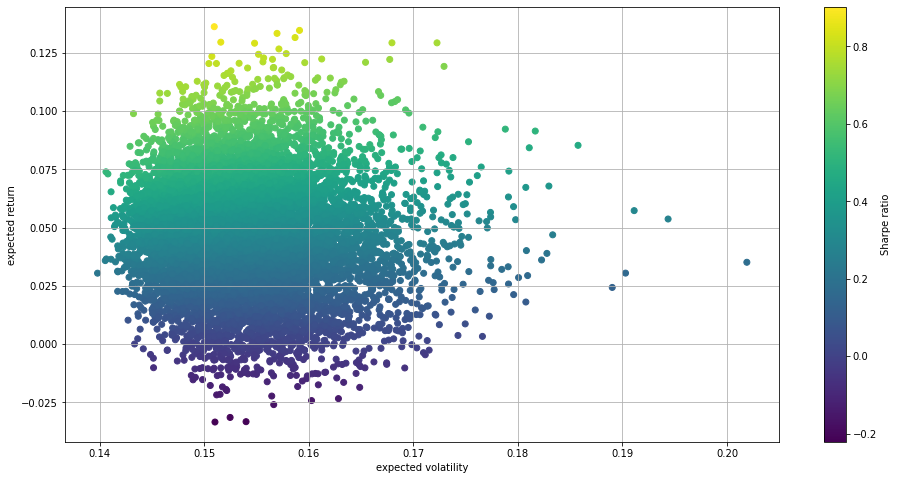

In [1282]:
plt.figure(figsize=(16, 8))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

Creating an array wityh nine different target volatilites. 
Each target evenly spaced from one another, representing the target volatility for the nine different portfolios. The lowest target is the lowest possible portfolio volatility. The highest target is the highest possible portfolio volatility. 

In [1283]:
target_vol = []
spread = (volmax - volmin) / 8
target_vol.append(volmin)
for i in range(0, 8):
    target_vol.append(target_vol[i] + spread)


Here I am using sco.minimize to find the optimal portfolio based on the Sharpe Ratio. As a constraint I have added the volatility target, resulting in the weights adding up to approach the correct volatility. 

In [1284]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * open_days
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * open_days, weights))) # square root ()
    return np.array([pret, pvol, pret / pvol])

'''
  Finds the sharpe ratio. The statistics calculates the sharpe ratio for the current weights, and since I am using
  the minimsation function it sets that sharpe ratio to be negative. That way the function is able to approach the
  best sharpe ratio possible. 
'''
def min_func_sharpe(weights):          
    return -statistics(weights)[2] 

def volatility(weights):
    return statistics(weights)[1]

def opt_portfolio(target_vol):
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1},
           {'type': 'eq', 'fun': lambda x:  volatility(x) - target_vol})   # Constraint to approach target volatility.

    bnds = tuple((0, 1) for x in range(noa)) # This is used below as a function
    opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                        bounds=bnds, constraints=cons)
    sh_weights = opts['x'].round(3)
    rets = statistics(opts['x'])[0]
    vols = statistics(opts['x'])[1]
    sharpe = statistics(opts['x'])[2]
    
    return sh_weights, rets, vols, sharpe

opt_portfolio(target_vol[8])

(array([0.   , 0.648, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.352]),
 0.2553356055188441,
 0.2018900003735748,
 1.2647263611192938)

Method that returns the portfolio performance for the last year. Given the structure of the dataframe this should just be the last 252 rows as there are 252 rows in a trading year.

In [1285]:
def index_to_share(i):
    shares = list(shareprices)
    return shares[i]

def weighted_return(portfolio, weights):
    ret = 0
    for i in range(0, len(portfolio)):
        ret += portfolio[i] * weights[i]
    return ret
    
def get_portfolio_perf(weigths, shares):
    port_perf = pd.DataFrame()
    # Get the relevaant share prices of the last year
    delete = []
    for i, share in enumerate(weights):
        if share != 0:
            port_perf[str(i)] = shares[index_to_share(i)].tail(252)
        else:
            delete.append(i)

    # Remove 0's from weights  
    p_weigths = np.delete(weights, delete, axis=0)
    
    # Calculate the individual returns
    port_perf = port_perf.pct_change() 
    rets = ['NaN']
    
    # Add them together based on weights
    for i, row in port_perf[1:].iterrows():
        ret = weighted_return(row, p_weigths)
        rets.append(ret)
    
    port_perf["return"] = rets
    return port_perf

weights = opt_portfolio(target_vol[8])[0]
get_portfolio_perf(weights, shareprices)

,1,9,return
Date,,,
17/4/2019,NaN,NaN,NaN
18/4/2019,-0.013055,-0.010302,-0.012086
19/4/2019,0.000000,0.000000,0
22/4/2019,0.000000,0.000000,0
23/4/2019,-0.000735,0.023595,0.00782915
...,...,...,...
27/3/2020,-0.075731,-0.009084,-0.0522714
30/3/2020,0.120235,0.108544,0.11612
31/3/2020,-0.051171,-0.045981,-0.0493437


#### Method that returns the index for the last year. ####
Given the structure of the dataframe this should just be the last 252 rows as there are 252 rows in a trading year.

In [1286]:
def get_index_perf(index):
    return index.tail(252).pct_change() 


#### Method that compares index and portfolio performance in the last year. ####
Plots a graph showing the varying returns over the last year. Returns two numbers, one for index return, other for portfolio return.

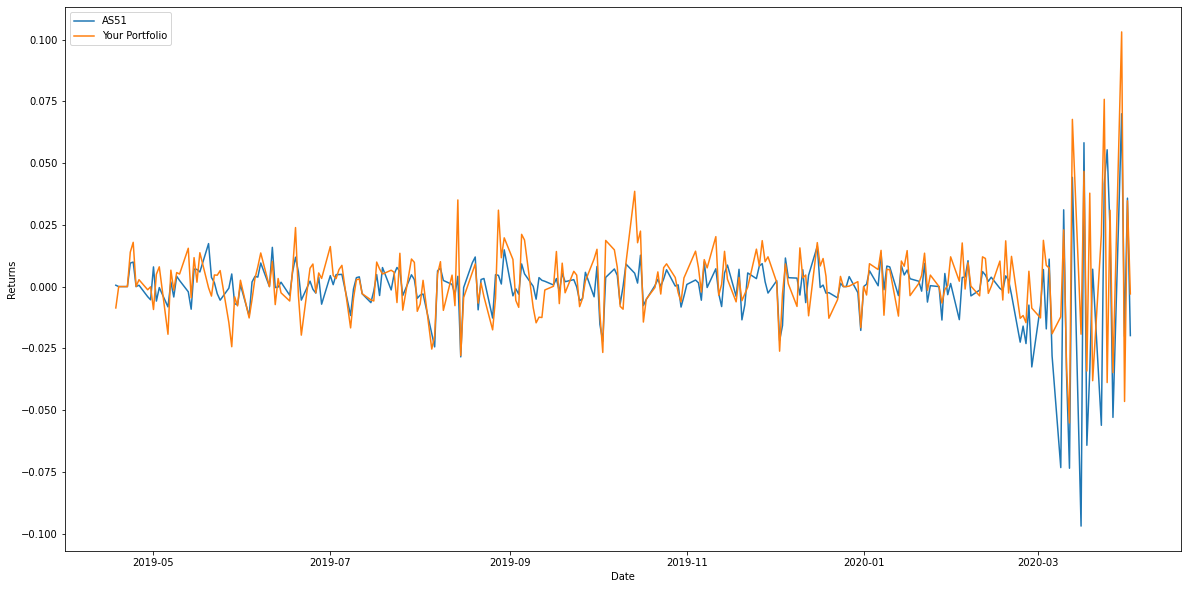

(0.5891300921223809, -0.16011239822211976)

In [1287]:
def compare_ind_port(p_rets, i_rets):
    p_ret = 0
    for i, row in enumerate(p_rets["return"][1:]):
        p_ret += float(row)
    i_ret = 0
    for i, row in i_rets[1:].iterrows():
        i_ret += row[0]

    # Plot the two graphs 
    i_rets.index = pd.to_datetime(i_rets.index, format="%d/%m/%Y")
    p_rets.index = pd.to_datetime(p_rets.index, format="%d/%m/%Y")
    p_rets["return"] = p_rets["return"].astype(float)
    
    plt.plot(i_rets.index, i_rets["AS51"], label="AS51")
    plt.plot(p_rets.index, p_rets["return"], label="Your Portfolio")
    plt.xlabel("Date")
    plt.ylabel("Returns")
    plt.legend()
    
    plt.show()
    
    return p_ret, i_ret

weights = opt_portfolio(target_vol[6])[0]
p_rets = get_portfolio_perf(weights, shareprices)
i_rets = get_index_perf(index)
compare_ind_port(p_rets, i_rets)

### Creating economic indicator charts ###

Method that plots the real_GDP growth as an indicator of portfolio performance. 

In [1288]:
def plot_real_gdp(e_indicators):
    fig, axs = plt.subplots()
    axs.plot(e_indicators["Date"], e_indicators["Real GDP Growth"], color="black")
    axs.set_xlabel("Date")
    axs.set_ylabel("Real GDP Growth")
    plt.show()

Method that plots the Consumer Price Index change as a measure of inflation and an indicator of portfolio performance

In [1289]:
def plot_CPI(e_indicators):
    fig, axs = plt.subplots()
    axs.plot(e_indicators["Date"], e_indicators["CPI"], color="black")
    axs.set_xlabel("Date")
    axs.set_ylabel("CPI")
    plt.show()

### Sentiment analysis ###

Performs the sentiment anlysis. Returns the mean + the scores

In [1290]:
def sent_analysis(news):
    # Instantiate the sentiment intensity analyzer
    vader = SentimentIntensityAnalyzer()

    # Iterate through the headlines and get the polarity scores using vader
    scores = news['Headline'].apply(vader.polarity_scores).tolist()
    
    # Convert the 'scores' list of dicts into a DataFrame
    scores_df = pd.DataFrame(scores)
    scores_df["Equity"] = news["Equity"]
    scores_df["Headline"] = news["Headline"]
    scores_df["Date"] = news["Date/Time"]
    
    cmp_mean = scores_df["compound"].mean()
    return cmp_mean, scores_df
sent_analysis(news)

(0.0613288888888889,
      neg    neu    pos  compound Equity  \
 0    0.0  1.000  0.000    0.0000    BHP   
 1    0.0  1.000  0.000    0.0000    BHP   
 2    0.0  1.000  0.000    0.0000    BHP   
 3    0.0  1.000  0.000    0.0000    BHP   
 4    0.0  1.000  0.000    0.0000    BHP   
 ..   ...    ...    ...       ...    ...   
 400  0.0  1.000  0.000    0.0000    FPH   
 401  0.0  1.000  0.000    0.0000    FPH   
 402  0.0  1.000  0.000    0.0000    FPH   
 403  0.0  1.000  0.000    0.0000    FPH   
 404  0.0  0.847  0.153    0.4404    FPH   
 
                                               Headline                 Date  
 0     BHP Group downgraded to hold from add at Morgans  22 Jul '20 10:05 AM  
 1    BHP Group Ltd.(BHP-AU) Schedules Q4 2020 Sales...  21 Jul '20 03:05 PM  
 2    BHP Group provides FY21 production guidance (A...  21 Jul '20 08:49 AM  
 3    CORRECTION: BHP Group reports Q4 production (A...  21 Jul '20 08:41 AM  
 4    StreetAccount Metrics Recap - BHP Billiton Q4 ..

#### Extracts the mean sentiment for the portfolio ####

Takes the mean sentiment of only the equities included in the portfolio. 

In [1291]:
def portfolio_sentiment(sentiment_scores, portfolio_weights):
    port_sent = []
    for i, share in enumerate(portfolio_weights):
        if share != 0:
            port_sent.append(index_to_share(i))
    
    sentiment = 0
    count = 0
    
    for i, row in sentiment_scores.iterrows():
        if row[4] in port_sent:
            sentiment += row[3]
            count += 1
    return sentiment / count
portfolio_sentiment(sent_analysis(news)[1], [0.0, 0.293, 0.153, 0.0, 0.034, 0.0, 0.0, 0.075, 0.0, 0.446])

0.06046586826347306

## Station 4: Model Implementation ##

Due to the constraints of this project I will in station 4 runs through all the code above. Hit Cell -> Run all, and watch what happens. Will run the methods in station 3 from here and create an example portfolio for someone with risk porfile number 6.

First I find the optimal portfolio:

In [1292]:
weights, rets, vol, sharpe = opt_portfolio(target_vol[5])
print(weights)
print(rets)
print(vol)
print(sharpe)

[0.    0.333 0.14  0.    0.005 0.    0.    0.033 0.    0.489]
0.23420567866083772
0.17860981806952594
1.311269902137577


Then I want to see the portfolio performance, that means the portfolio returns

In [1293]:
p_rets = get_portfolio_perf(weights, shareprices)
print(p_rets)

                  1         2         4         7         9      return
Date                                                                   
17/4/2019       NaN       NaN       NaN       NaN       NaN         NaN
18/4/2019 -0.013055  0.013900  0.005151  0.000000 -0.010302 -0.00741326
19/4/2019  0.000000  0.000000  0.000000  0.000000  0.000000           0
22/4/2019  0.000000  0.000000  0.000000  0.000000  0.000000           0
23/4/2019 -0.000735  0.015040  0.014414  0.010403  0.023595   0.0138141
...             ...       ...       ...       ...       ...         ...
27/3/2020 -0.075731 -0.026665 -0.052546 -0.007911 -0.009084  -0.0339176
30/3/2020  0.120235  0.020518  0.095977  0.036683  0.108544   0.0976792
31/3/2020 -0.051171 -0.033927 -0.079706  0.003077 -0.045981  -0.0445712
1/4/2020   0.034785  0.045288  0.025926  0.036043  0.032594    0.035181
2/4/2020   0.004137 -0.011312 -0.006665 -0.011843 -0.006044 -0.00358597

[252 rows x 6 columns]


Plotting the portfolio performance against the index gives:

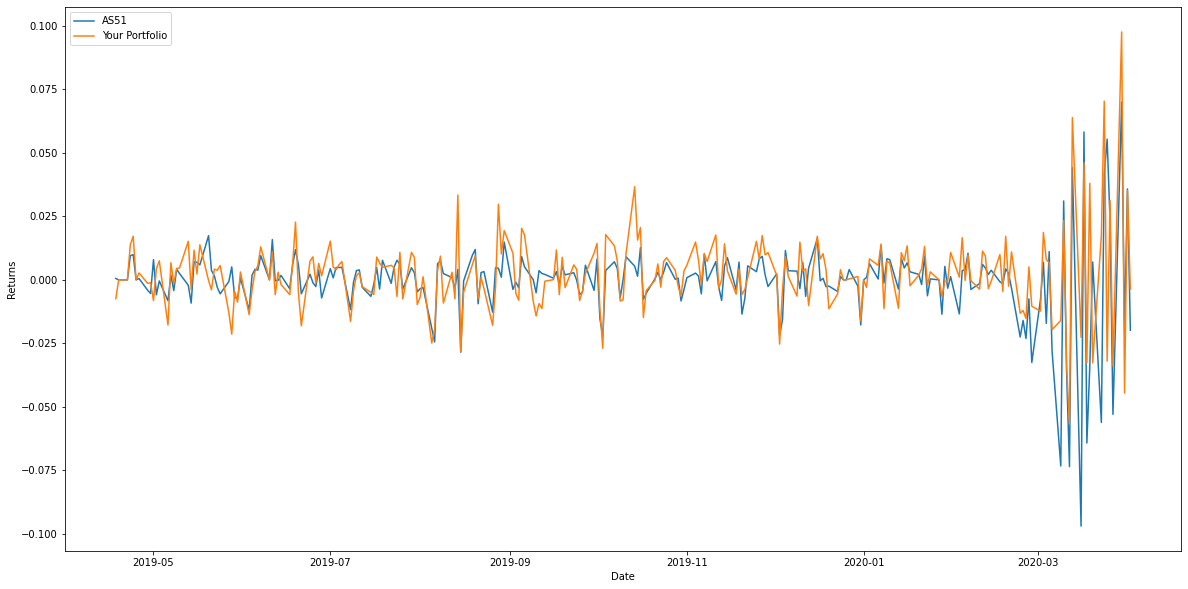

The protfolios average annual return is: 53.8%
The index average annual return is: -16.01%


In [1294]:
p, i = compare_ind_port(p_rets, i_rets)
print("The protfolios average annual return is: " + str(round(p * 100, 2)) + "%")
print("The index average annual return is: " + str(round(i * 100, 2)) + "%")

As an indicator to explain the portfolios performance I wish to plot real GDP and the CPI to compare.

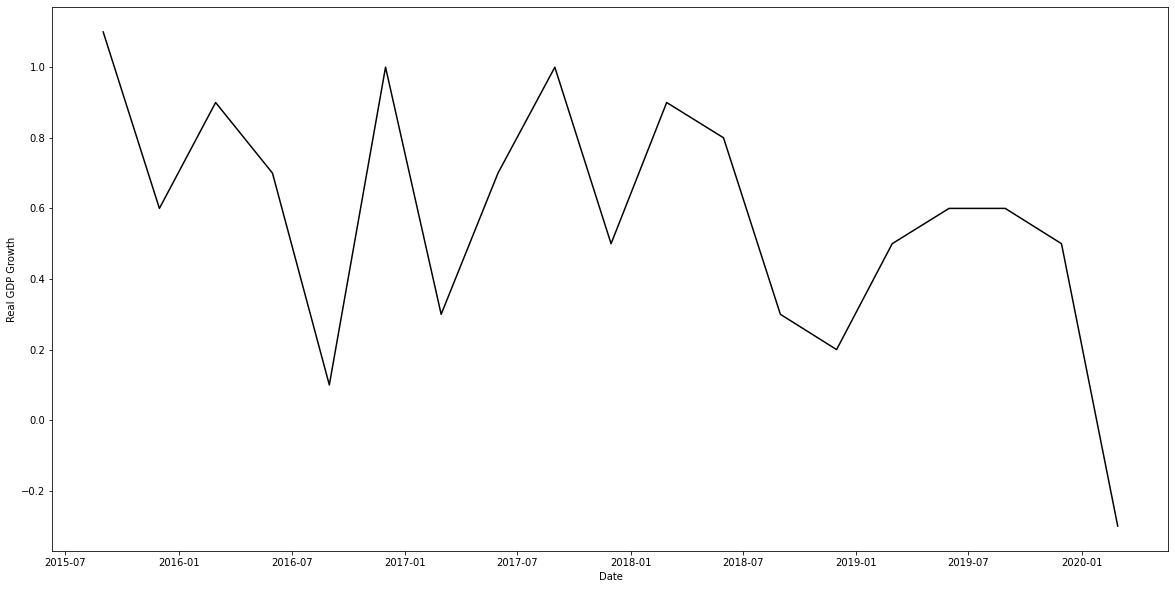

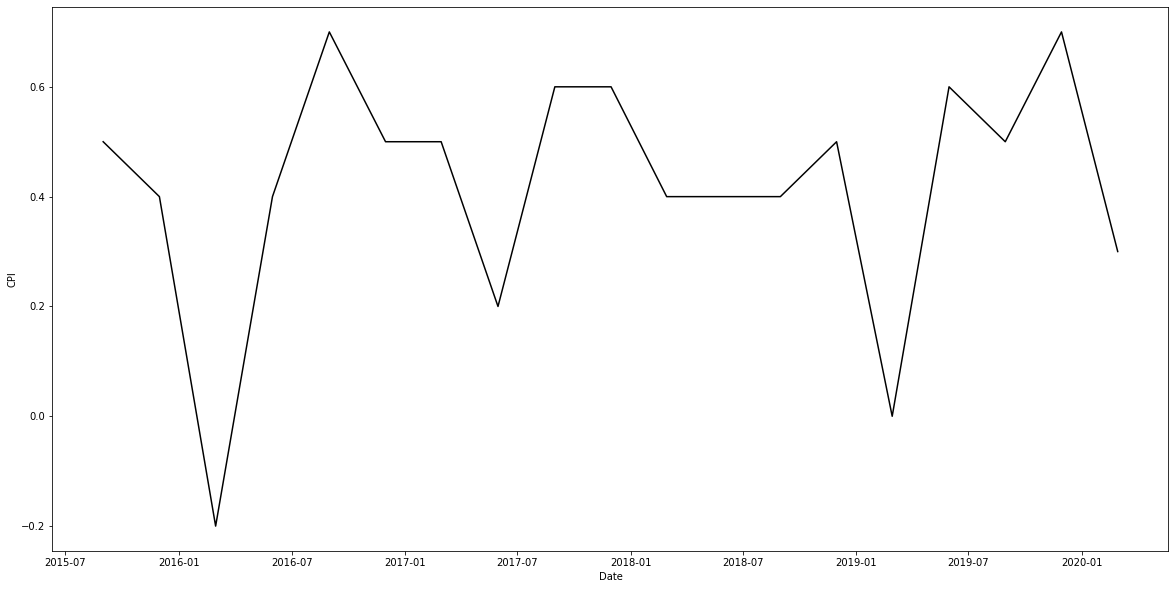

In [1295]:
plot_real_gdp(e_indicators)
plot_CPI(e_indicators)

Another indicator of the protfolios performance is the sentiment drawn from news articles. Only including the stock in the portfolios I find the following sentiment. 

In [1296]:
sentiment = portfolio_sentiment(sent_analysis(news)[1], weights)
if sentiment > 0:
    print("The sentiment surrounding the companies included in your portfolio has been positive.")
else:
    print("The sentiment surrounding the companies included in your portfolio has been negative.")

The sentiment surrounding the companies included in your portfolio has been positive.
